In [1]:
!pip install nltk
!pip install textblob
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


In [11]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud

In [12]:
filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.width",200)
pd.set_option("display.float_format",lambda x:"%.2f" % x)

In [13]:
#Text PreProcessing

df=pd.read_csv("nlp/datasets/amazon_reviews.csv",sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [14]:
#Normalizing Case Folding

df["reviewText"]=df["reviewText"].str.lower()
df["reviewText"]

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [15]:
#Punctuations
df["reviewText"]=df["reviewText"].str.replace("[^\w\s]"," ",regex=True)
df["reviewText"].head()

0                                           no issues 
1    purchased this for my device  it worked as adv...
2    it works as expected  i should have sprung for...
3    this think has worked out great had a diff  br...
4    bought it with retail packaging  arrived legit...
Name: reviewText, dtype: object

In [16]:
#Numbers
df["reviewText"]=df["reviewText"].str.replace("\d"," ")
df["reviewText"]

0                                              no issues 
1       purchased this for my device  it worked as adv...
2       it works as expected  i should have sprung for...
3       this think has worked out great had a diff  br...
4       bought it with retail packaging  arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable  it ...
4913    good amount of space for the stuff i want to d...
4914    i ve heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

In [17]:
#Stop Words
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ertuğrul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
sw=stopwords.words("english")
df["reviewText"]=df["reviewText"].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["reviewText"].head()

0                                               issues
1    purchased device worked advertised never much ...
2    works expected sprung higher capacity think ma...
3    think worked great diff bran 64gb card went so...
4    bought retail packaging arrived legit orange e...
Name: reviewText, dtype: object

In [19]:
#Rare Words

temp_df=pd.Series(" ".join(df["reviewText"]).split()).value_counts()
drops=temp_df[temp_df <= 1]

df["reviewText"]=df["reviewText"].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df["reviewText"].head()

0                                               issues
1    purchased device worked advertised never much ...
2    works expected higher capacity think made bit ...
3    think worked great 64gb card went south 3 mont...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

In [20]:
#Tokenization
#nltk.download("punkt")
from textblob import TextBlob
df["reviewText"].apply(lambda x: TextBlob(x).words).head()

0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, higher, capacity, think, mad...
3    [think, worked, great, 64gb, card, went, south...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [21]:
#Lemmatization
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ertuğrul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [22]:
df["reviewText"]= df["reviewText"].apply(lambda x : " ".join([Word(word).lemmatize() for word in x.split()]))
df["reviewText"]

0                                                   issue
1       purchased device worked advertised never much ...
2       work expected higher capacity think made bit e...
3       think worked great 64gb card went south 3 mont...
4       bought retail packaging arrived legit envelope...
                              ...                        
4910    bought sandisk 16gb class 10 use htc inspire 3...
4911    used capability samsung galaxy note 10 greatly...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    heard bad thing 64gb micro sd card crapping we...
Name: reviewText, Length: 4915, dtype: object

In [23]:
#Text Visualization
#Terim Frekanslarının Oluşturulması

tf=df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns=["words","tf"]
tf.sort_values("tf",ascending=False)

,words,tf
27,card,5656.00
14,work,2081.00
7,phone,1977.00
45,great,1481.00
8,memory,1391.00
...,...,...
2910,nuisance,2.00
2907,dialog,2.00
2905,dying,2.00
2903,evening,2.00


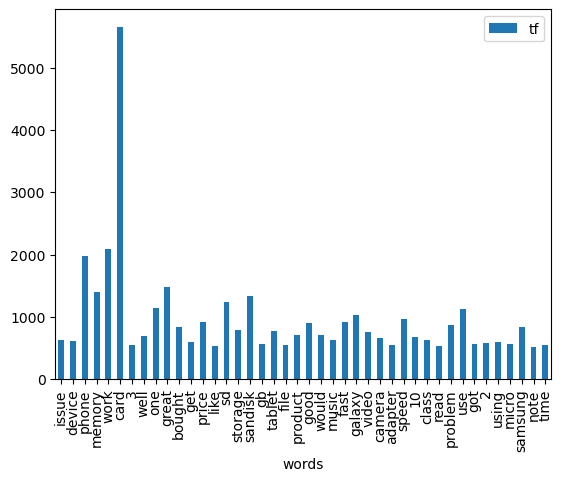

In [24]:
#Barplot

tf[tf["tf"]>500].plot.bar(x="words",y="tf")
plt.show()

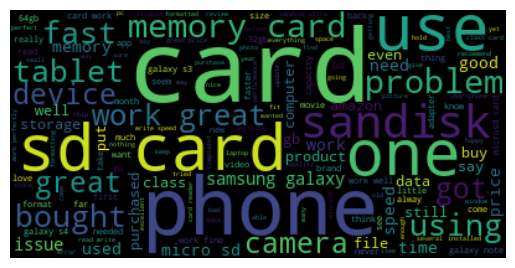

In [25]:
#WordCloud

text = " ".join(i for i in df.reviewText)

wordcloud= WordCloud().generate(text)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()


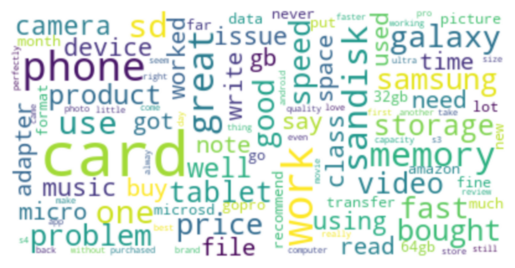

In [26]:
wordcloud2=WordCloud(max_font_size=50,
                     max_words=100,
                     background_color="white",
                     collocations=False).generate(text)
plt.figure()
plt.imshow(wordcloud2,interpolation="bicubic")
plt.axis("off")
plt.show()
#wordcloud2.to_file("wordcloud.png")
#WordCloud içine collocations=False parametresini eklersek birden çok kez aynı terimi göstermez.



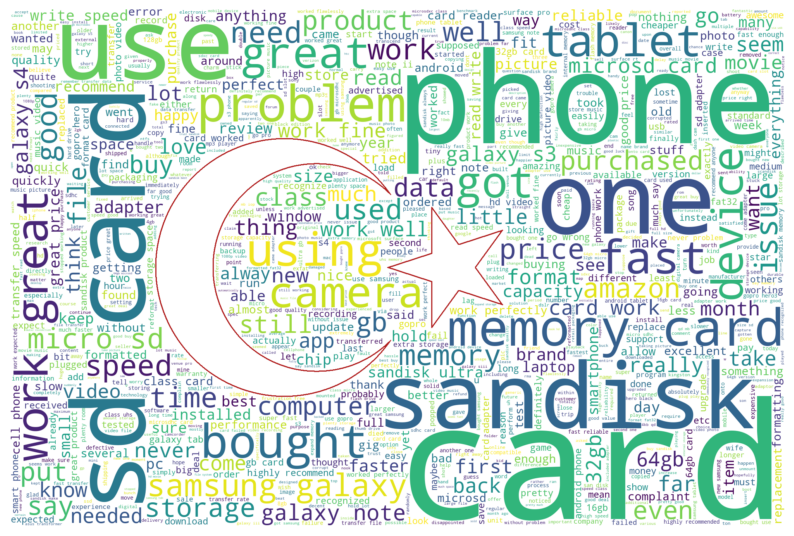

In [27]:
tr_mask=np.array(Image.open("nlp/tr.png"))

wc=WordCloud(background_color="white",
             max_words=1000,
             mask=tr_mask,
             contour_width=3,
             contour_color="firebrick")

wc.generate(text)
plt.figure(figsize=[10,10])
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
#Sentiment Analysis

nltk.download("vader_lexicon")

sia=SentimentIntensityAnalyzer()

sia.polarity_scores("I liked it but it is not good as the other one")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ertuğrul\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


{'neg': 0.222, 'neu': 0.642, 'pos': 0.136, 'compound': -0.298}

In [29]:
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

0   0.00
1   0.00
2   0.40
3   0.92
4   0.86
5   0.00
6   0.87
7   0.74
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [30]:
df["polarity_score"]=df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])


In [31]:
#Case 1: overall >= 3 and compound < 0 (high score but negative reviews)
pd.set_option("display.max.colwidth",None)
high_score_negative_reviews=df[(df["overall"] ==5 ) & (df["polarity_score"] <0)][["overall","reviewText"]]
high_score_negative_reviews.value_counts

<bound method DataFrame.value_counts of       overall  \
14       5.00   
19       5.00   
20       5.00   
24       5.00   
34       5.00   
...       ...   
4861     5.00   
4864     5.00   
4886     5.00   
4898     5.00   
4907     5.00   

                                                                                                                                                                                                                                                                                                                                                                                                       reviewText  
14                                                                                                                                                                                                                                                                                                                                    heard card write speed in

In [32]:

low_score_positive_reviews=df[(df["overall"] ==1 ) & (df["polarity_score"] >0)][["overall","reviewText","polarity_score"]]
low_score_positive_reviews.head() 

,overall,reviewText,polarity_score
38,1.00,bougth micro sd card got kingston tell sandisk quality best i9300 phone read 64gb fast transfer speed pc amazing looking additional storage phone music picture type file pro good quality material construction amazing one year memory damaged delete put new file format memory tried format phone pc camera nothing like 64gb cd data memory available read move delete bought memory used backup data android device readable memory write data hope sandisk make better product future total buy samsung memory card expected better quality,0.96
177,1.00,use sdxc card 128gb card unreadable arrival pc said needed formatted last resort let one try window 7 date sdxc driver could format way back amazon glad return easy,0.77
213,1.00,used sandisk photography course went time new samsung galaxy s3 internal microsd card spent extra buck comparably name micro sd card bought variant took quite picture even transferred album computer show friend go less two month sandisk microsd card started acting recognized stopped restarted removed reinstalled onto phone behavior taken immediately tried recover anything could thing hit fan unfortunately waited long morning reason turned phone card show blank neither window pc mac even detect card yes tried two different adapter tried sandisk recovery found recoverable file even though checked file type apparently lost picture top gf cheap name card never issue exact phone keep chugging along paying premium product fails use two month thanks going back lexar failed yet also getting rid sandisk card dslr case fact sandisk first card thats ever failed new card boot inspire confidence buy use risk,0.42
217,1.00,bought card 64gb sandisk phone right gift friend mine sadly corrupted within minute first use initially worked fine dead checked laptop window disk management screen told single partition rest unusable outstanding replacement sent amazon thank amazon always excellent sitting office right probably check,0.91
295,1.00,card got hot almost crazy card somewhere else know wii taking chance one device thanks,0.42


In [33]:
#Sentiment Modeling

df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"]=df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["sentiment_label"].value_counts()

df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

y= df["sentiment_label"]

X= df["reviewText"] # ölçülebilir, üzerinde matematiksel işlemler yapılabilir hale getirmemiz gerekir(Bu haliyle sadece bir text)




In [34]:
#Elimdeki numerik olmayan metinleri numeriğe çevirebileyim ki üzerinde ML algoritmalarını
#kullanabileyim. Bunun için en yaygın olan 3 metod:

#Count Vectors: frekans temsiller
#TF-IDF Vectors: normalize edilmiş frekans temsiller
#Word Embeddings (Word2Vec, GloVe, BERT vs)

#Bu yukarıdaki 3 metodu da kendi içlerinde 3farklı aşağıdaki yapı ile birleştirerek kullanabiliriz.
# words - kelimelerin numerik temsilleri

# characters - karakterlerin numerik temsilleri

# ngram - N-gram'lar birlikte kullanılan kelimelerin kombinasyonlarını gösterir ve feature üretmek için kullanılır.
a = "N Gram calisma mantigi islenisi"

TextBlob(a).ngrams(3)

[WordList(['N', 'Gram', 'calisma']),
 WordList(['Gram', 'calisma', 'mantigi']),
 WordList(['calisma', 'mantigi', 'islenisi'])]

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

corpus= ["This is the first document.",
         "This document is the second document.",
         "And this is the third one.",
         "Is this the first document?"]

# Count Vector - words frekans

vectorizer= CountVectorizer()
X_c = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(X_c.toarray())

print("\n# # # # # # # # # # # # # \n")


# Count Vector - ngram frekans

vectorizer2= CountVectorizer(analyzer="word",ngram_range=(2,2))
X_n=vectorizer2.fit_transform(corpus)
print(vectorizer2.get_feature_names_out())
print(X_n.toarray())





['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]

# # # # # # # # # # # # # 

['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']
[[0 0 1 1 0 0 1 0 0 0 0 1 0]
 [0 1 0 1 0 1 0 1 0 0 1 0 0]
 [1 0 0 1 0 0 0 0 1 1 0 1 0]
 [0 0 1 0 1 0 1 0 0 0 0 0 1]]


In [36]:
vectorizer3= CountVectorizer()
X_count=vectorizer3.fit_transform(X)

print(vectorizer3.get_feature_names_out()[10:15])

X_count.toarray()[10:15]

['10' '100' '1000' '100gb' '100mb']


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [37]:
#TF-IDF Vectors: normalize edilmiş frekans temsiller
#TF-IDF, Count Vector yönteminin ortaya çıkarabileceği bazı yanlılıkların önüne geçmesi beklenir.
#Kelimelerin hem bulunduğu satırdaki sıklıkları, hem de diğer tüm satırlardaki sıklıkları göz önünde bulundurularak yapılan bir normalizasyon işlemi.

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_word_vectorizer=TfidfVectorizer()
X_tf_idf_word=tf_idf_word_vectorizer.fit_transform(X)

tf_idf_ngram_vectorizer=TfidfVectorizer(ngram_range=(2,3))
X_tf_idf_ngram=tf_idf_ngram_vectorizer.fit_transform(X)




In [38]:
#Sentiment Modeling
#Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model= LogisticRegression().fit(X_tf_idf_word,y)

cross_val_score(log_model,
                X_tf_idf_word,
                y,
                scoring="accuracy",
                cv=5).mean()


#Yeni bir yorumu denemek için, yorumu vectorizer ile öğrenmeye uygun hale getirmeliyiz.
new_review=pd.Series("this product is great.")

new_review=TfidfVectorizer().fit(X).transform(new_review)

log_model.predict(new_review)

random_review=pd.Series(df["reviewText"].sample(1).values)

new_review2=TfidfVectorizer().fit(X).transform(random_review)


log_model.predict(new_review2)


array([0])

In [ ]:
#Random Forest


#Count Vectors
rf_model=RandomForestClassifier().fit(X_count,y)
cross_val_score(rf_model,X_count,y,cv=5,n_jobs=-1).mean()
#0.8465



#TF-IDF Word-Level
rf_model=RandomForestClassifier().fit(X_tf_idf_word,y)
cross_val_score(rf_model,X_tf_idf_word,y,cv=5,n_jobs=-1).mean()
#0.8315


#TF-IDF N-Gram

rf_model=RandomForestClassifier().fit(X_tf_idf_ngram,y)
cross_val_score(rf_model,X_tf_idf_ngram,y,cv=5,n_jobs=-1).mean()

#0.7863

0.7863682604272635

In [40]:
#Hiperparametre Optimizasyonu

rf_model= RandomForestClassifier(random_state=17)

rf_params={"max_depth":[8,None],
           "max_features":[7,"auto"],
            "min_samples_split":[2,5,8],
            "n_estimators":[100,200]}


rf_best_grid=GridSearchCV(rf_model,rf_params,cv=5,n_jobs=-1,verbose=True).fit(X_count,y)

rf_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'max_depth': None,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 100}

In [41]:
rf_final=rf_model.set_params(**rf_best_grid.best_params_, random_state=17).fit(X_count,y)

cross_val_score(rf_final,X_count,y,cv=5,n_jobs=-1).mean()

0.8417090539165818